In [1]:
import numpy as np
import cvxpy as cp
from scipy.io import loadmat
import pandas as pd
from network import *
import matplotlib.pyplot as plt

First, read in problem parameters. These can come from any source, but they should be reshaped into a `pandas.DataFrame` object with the format shown here

In [2]:
# System base in MVA, taken from PowerWorld. Used to convert from MW to per-unit.
base = 100

transition = .9

# Key/value pairs are the names and contents of the sheets in the excel model data
model_df = pd.read_excel('Example11_9_Network_Model_Jul19.xlsx', sheet_name=None)

# The initial conditions of the demand curves
load = model_df['LoadProfiles'].set_index('Date')
load.index+=pd.TimedeltaIndex(load.HE-1, unit='h')
load = load.drop(columns='HE')
demand = load.loc[:,load.columns.str.contains('Load')]/base
demand.columns = demand.columns.str.replace('Load','').astype(int)
price = load.loc[:,load.columns.str.contains('Price')]
price.columns = price.columns.str.replace('Price','').astype(int)

# Generation profiles for intermittant sources
int_gen = pd.read_excel('Normalized generation profiles.xlsx', sheet_name='Normalized', index_col=0)
int_gen.index+=pd.TimedeltaIndex(int_gen.HE-1, unit='h')
int_gen = int_gen.drop(columns='HE')
int_gen = int_gen.loc[load.index, model_df['Gen']['Type']]
int_gen = int_gen*np.array(model_df['Gen']['Installed MW'])/base
int_gen.columns = np.array(model_df['Gen']['Number of Bus'])

# Set elasticity constant, for now
epsilon = demand.copy()
epsilon[:] = -.5

voll = price.copy()
voll[:] = price*2

profile = pd.concat(
    {
        'nom_load': demand,
        'nom_price': price,
        'elasticity': epsilon,
        'voll': voll,
        'int_gen': transition*int_gen
    },
    axis='columns'
)

profile

nom_load                                nom_price  \
                            2         3         4         5          2   
2040-07-19 00:00:00  1.354635  1.342951  0.239728  0.007159   85.31474   
2040-07-19 01:00:00  1.283271  1.268229  0.233686  0.006635   77.88892   
2040-07-19 02:00:00  1.230823  1.211139  0.236097  0.006210   77.28072   
2040-07-19 03:00:00  1.225253  1.165163  0.230172  0.006037   73.84972   
2040-07-19 04:00:00  1.218273  1.153589  0.224718  0.005993   75.56156   
2040-07-19 05:00:00  1.218426  1.174334  0.221472  0.006122   77.32375   
2040-07-19 06:00:00  1.267046  1.211282  0.226422  0.006469   93.69326   
2040-07-19 07:00:00  1.333737  1.319292  0.253146  0.008453   69.55161   
2040-07-19 08:00:00  1.384030  1.425086  0.246184  0.010500   65.43482   
2040-07-19 09:00:00  1.335695  1.506713  0.232573  0.011358   66.06382   
2040-07-19 10:00:00  1.276514  1.585213  0.232012  0.012185   68.32093   
2040-07-19 11:00:00  1.306467  1.680898  0.234693  0.013165   72.84008   
2040-07-19 12:00:00  1.342153  1.751601  0.240295  0.012876   77.56588   
2040-07-19 13:00:00  1.418329  1.846141  0.252518  0.012259   82.13918   
2040-07-19 14:00:00  1.494919  1.936568  0.263823  0.012795   87.24515   
2040-07-19 15:00:00  1.574338  2.010799  0.282777  0.013242   94.68144   
2040-07-19 16:00:00  1.656024  2.038054  0.312281  0.013467   99.00778   
2040-07-19 17:00:00  1.731648  2.044997  0.327822  0.013623  108.48612   
2040-07-19 18:00:00  1.779561  1.991444  0.342184  0.013450  126.82540   
2040-07-19 19:00:00  1.783140  1.904501  0.343932  0.012727  172.06349   
2040-07-19 20:00:00  1.731051  1.828607  0.326119  0.011790  136.37447   
2040-07-19 21:00:00  1.657311  1.741642  0.310811  0.010581  117.12273   
2040-07-19 22:00:00  1.532603  1.591900  0.288723  0.009494   93.68556   
2040-07-19 23:00:00  1.415928  1.463462  0.267013  0.008467   90.09938   

                                                     elasticity            \
                             3          4          5          2    3    4   
2040-07-19 00:00:00   79.97630   81.97032   78.36793       -0.5 -0.5 -0.5   
2040-07-19 01:00:00   69.33950   71.02853   67.16129       -0.5 -0.5 -0.5   
2040-07-19 02:00:00   68.88738   70.09301   67.06882       -0.5 -0.5 -0.5   
2040-07-19 03:00:00   68.90495   69.92739   67.17734       -0.5 -0.5 -0.5   
2040-07-19 04:00:00   68.77653   69.75000   67.21834       -0.5 -0.5 -0.5   
2040-07-19 05:00:00   71.87760   72.79417   70.42926       -0.5 -0.5 -0.5   
2040-07-19 06:00:00   95.76965   97.17286   94.28110       -0.5 -0.5 -0.5   
2040-07-19 07:00:00   69.79308   71.73846   67.51065       -0.5 -0.5 -0.5   
2040-07-19 08:00:00   65.38457   67.77990   62.59464       -0.5 -0.5 -0.5   
2040-07-19 09:00:00   66.51568   69.18088   62.27473       -0.5 -0.5 -0.5   
2040-07-19 10:00:00   69.54962   71.01485   64.42512       -0.5 -0.5 -0.5   
2040-07-19 11:00:00   75.14882   76.73858   69.86052       -0.5 -0.5 -0.5   
2040-07-19 12:00:00   88.94747   88.16511   83.72115       -0.5 -0.5 -0.5   
2040-07-19 13:00:00   97.07884   95.94236   89.96172       -0.5 -0.5 -0.5   
2040-07-19 14:00:00  105.39469  104.07146   97.52411       -0.5 -0.5 -0.5   
2040-07-19 15:00:00  116.86232  116.52516  110.91525       -0.5 -0.5 -0.5   
2040-07-19 16:00:00  126.64739  125.81665  120.32268       -0.5 -0.5 -0.5   
2040-07-19 17:00:00  132.70206  131.98009  125.74452       -0.5 -0.5 -0.5   
2040-07-19 18:00:00  155.14903  153.70271  150.95392       -0.5 -0.5 -0.5   
2040-07-19 19:00:00  206.40636  205.17920  203.24863       -0.5 -0.5 -0.5   
2040-07-19 20:00:00  155.12260  153.79430  152.35048       -0.5 -0.5 -0.5   
2040-07-19 21:00:00  127.39566  129.34760  125.96109       -0.5 -0.5 -0.5   
2040-07-19 22:00:00   94.89950   95.56881   92.15713       -0.5 -0.5 -0.5   
2040-07-19 23:00:00   85.21710   86.66729   83.92821       -0.5 -0.5 -0.5   

                               voll                                   \
                     

To create the network mode, we also need the admittance matrix, line flow limits, storage duration, and generator limits/cost coefficients, as defined below.

In [3]:
# Process Ybus matrix
Y = model_df['YBus']
Y = Y.drop(columns=['Number', 'Name'])
Y = Y.apply(lambda row: row.str.replace('j', ''))
Y = Y.apply(lambda row: row.str.replace(' ', ''))
Y = Y + 'j'
Y = Y.fillna(0)
Y = Y.applymap(complex)
Y = np.array(Y)

# Number of buses
N = Y.shape[0]

# Susceptance matrix. Recall in DC power flow, G = 0 and shunt admittances are zero.
B = np.array(np.imag(Y))
B = B - np.diag(np.diag(B))
B = B - np.diag(np.sum(B, axis=0))

# Line constraints. The i, j element is the MVA limit of the line from bus i to bus j
P_line = np.zeros((N,N))
limits = model_df['Line']
P_line[limits['From Number']-1, limits['To Number']-1] = limits['Lim A MVA']
P_line = (P_line+P_line.T)/base

# Number of timesteps to fully charge/discharge storage
b_duration = 4

# Dispatchable generator costs, in the form [linear; quadratic]
cost_coeffs = np.array(
    [
        [10,8,12],
        [.016,0.18,0.18]
    ]
)

# Generator limits
dis_max = (1-transition)*np.array(model_df['Gen']['Installed MW'])/base

Instantiate model

In [4]:
model = Network(
    B=B,
    line_lims=P_line,
    profile=profile,
    dis_max=dis_max,
    total_storage=2000/base,
    storage_cycle_timesteps=4,
    cost_coeffs=cost_coeffs
)

Solve model. This will add output data to the `model.profile` dataframe as well as the following model attributes:
- `model.storage_capacity`: the storage capacity allocated to each bus
- `model.initial_charge`: the initial state-of-charge of each storage unit

In [5]:
model.solve()
profile

nom_load                                nom_price  \
                            2         3         4         5          2   
2040-07-19 00:00:00  1.354635  1.342951  0.239728  0.007159   85.31474   
2040-07-19 01:00:00  1.283271  1.268229  0.233686  0.006635   77.88892   
2040-07-19 02:00:00  1.230823  1.211139  0.236097  0.006210   77.28072   
2040-07-19 03:00:00  1.225253  1.165163  0.230172  0.006037   73.84972   
2040-07-19 04:00:00  1.218273  1.153589  0.224718  0.005993   75.56156   
2040-07-19 05:00:00  1.218426  1.174334  0.221472  0.006122   77.32375   
2040-07-19 06:00:00  1.267046  1.211282  0.226422  0.006469   93.69326   
2040-07-19 07:00:00  1.333737  1.319292  0.253146  0.008453   69.55161   
2040-07-19 08:00:00  1.384030  1.425086  0.246184  0.010500   65.43482   
2040-07-19 09:00:00  1.335695  1.506713  0.232573  0.011358   66.06382   
2040-07-19 10:00:00  1.276514  1.585213  0.232012  0.012185   68.32093   
2040-07-19 11:00:00  1.306467  1.680898  0.234693  0.013165   72.84008   
2040-07-19 12:00:00  1.342153  1.751601  0.240295  0.012876   77.56588   
2040-07-19 13:00:00  1.418329  1.846141  0.252518  0.012259   82.13918   
2040-07-19 14:00:00  1.494919  1.936568  0.263823  0.012795   87.24515   
2040-07-19 15:00:00  1.574338  2.010799  0.282777  0.013242   94.68144   
2040-07-19 16:00:00  1.656024  2.038054  0.312281  0.013467   99.00778   
2040-07-19 17:00:00  1.731648  2.044997  0.327822  0.013623  108.48612   
2040-07-19 18:00:00  1.779561  1.991444  0.342184  0.013450  126.82540   
2040-07-19 19:00:00  1.783140  1.904501  0.343932  0.012727  172.06349   
2040-07-19 20:00:00  1.731051  1.828607  0.326119  0.011790  136.37447   
2040-07-19 21:00:00  1.657311  1.741642  0.310811  0.010581  117.12273   
2040-07-19 22:00:00  1.532603  1.591900  0.288723  0.009494   93.68556   
2040-07-19 23:00:00  1.415928  1.463462  0.267013  0.008467   90.09938   

                                                     elasticity            \
                             3          4          5          2    3    4   
2040-07-19 00:00:00   79.97630   81.97032   78.36793       -0.5 -0.5 -0.5   
2040-07-19 01:00:00   69.33950   71.02853   67.16129       -0.5 -0.5 -0.5   
2040-07-19 02:00:00   68.88738   70.09301   67.06882       -0.5 -0.5 -0.5   
2040-07-19 03:00:00   68.90495   69.92739   67.17734       -0.5 -0.5 -0.5   
2040-07-19 04:00:00   68.77653   69.75000   67.21834       -0.5 -0.5 -0.5   
2040-07-19 05:00:00   71.87760   72.79417   70.42926       -0.5 -0.5 -0.5   
2040-07-19 06:00:00   95.76965   97.17286   94.28110       -0.5 -0.5 -0.5   
2040-07-19 07:00:00   69.79308   71.73846   67.51065       -0.5 -0.5 -0.5   
2040-07-19 08:00:00   65.38457   67.77990   62.59464       -0.5 -0.5 -0.5   
2040-07-19 09:00:00   66.51568   69.18088   62.27473       -0.5 -0.5 -0.5   
2040-07-19 10:00:00   69.54962   71.01485   64.42512       -0.5 -0.5 -0.5   
2040-07-19 11:00:00   75.14882   76.73858   69.86052       -0.5 -0.5 -0.5   
2040-07-19 12:00:00   88.94747   88.16511   83.72115       -0.5 -0.5 -0.5   
2040-07-19 13:00:00   97.07884   95.94236   89.96172       -0.5 -0.5 -0.5   
2040-07-19 14:00:00  105.39469  104.07146   97.52411       -0.5 -0.5 -0.5   
2040-07-19 15:00:00  116.86232  116.52516  110.91525       -0.5 -0.5 -0.5   
2040-07-19 16:00:00  126.64739  125.81665  120.32268       -0.5 -0.5 -0.5   
2040-07-19 17:00:00  132.70206  131.98009  125.74452       -0.5 -0.5 -0.5   
2040-07-19 18:00:00  155.14903  153.70271  150.95392       -0.5 -0.5 -0.5   
2040-07-19 19:00:00  206.40636  205.17920  203.24863       -0.5 -0.5 -0.5   
2040-07-19 20:00:00  155.12260  153.79430  152.35048       -0.5 -0.5 -0.5   
2040-07-19 21:00:00  127.39566  129.34760  125.96109       -0.5 -0.5 -0.5   
2040-07-19 22:00:00   94.89950   95.56881   92.15713       -0.5 -0.5 -0.5   
2040-07-19 23:00:00   85.21710   86.66729   83.92821       -0.5 -0.5 -0.5   

                               voll                                   \
                     

Plot all the prices and their nominal values (dotted). Bus 1 has no nominal price because it does not have a load.

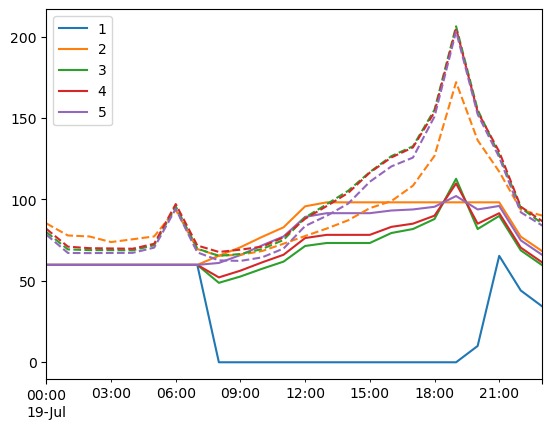

In [6]:
fig, ax = plt.subplots()
model.profile.price.plot(ax=ax)
# Save colors for consistency
colors = np.array([line.get_color() for line in ax.lines])
ax.set_prop_cycle(None)
model.profile.nom_price.plot(ax=ax,style='--',color=colors[model.profile.nom_price.columns-1],legend=False)
fig.show()

Similar idea with the loads - nominal dotted, actual solid

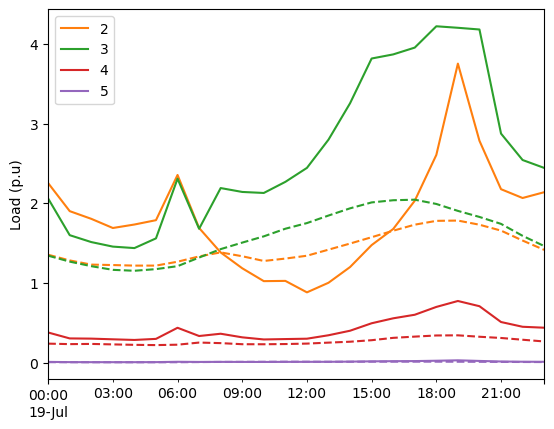

In [7]:
fig, ax = plt.subplots()
model.profile.load.plot(ax=ax,color=colors[model.profile.load.columns-1])
model.profile.nom_load.plot(ax=ax,style='--',color=colors[model.profile.load.columns-1],legend=False)
ax.set_ylabel('Load (p.u)')
fig.show()

Compute the dispatchable and intermittent (dotted) loads

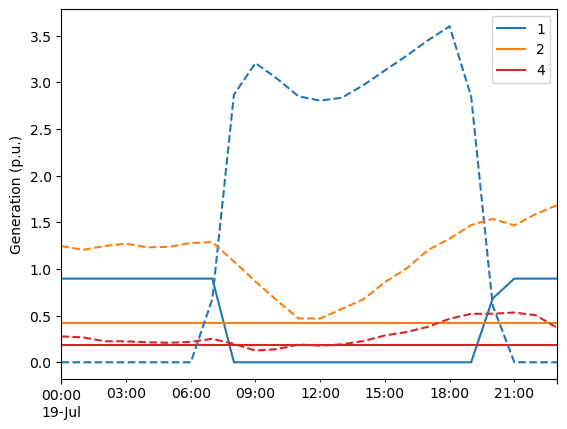

In [8]:
dispatchable = model.profile.generation - model.profile.int_gen
dispatchable[dispatchable < 0] = 0
intermittent = model.profile.generation - dispatchable

fig, ax = plt.subplots()
dispatchable.plot(ax=ax,color=colors[dispatchable.columns-1])
intermittent.plot(ax=ax,style='--',color=colors[intermittent.columns-1],legend=False)
ax.set_ylabel('Generation (p.u.)')
fig.show()

Compute producer (solid) and consumer (dashed) surplus according to:
- Consumer surplus = revenue - cost
- Producer surplus = utility - expenses

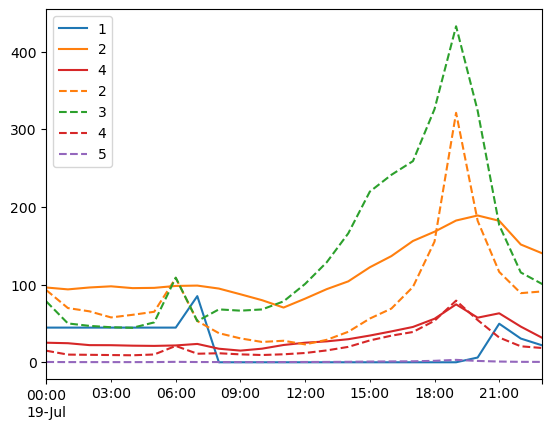

In [9]:
producer_surplus = model.profile.generation*model.profile.price[model.profile.generation.columns]-model.profile.cost
consumer_surplus = model.profile.utility - model.profile.load*model.profile.price[model.profile.load.columns]

fig, ax = plt.subplots()
producer_surplus.plot(ax=ax,color=colors[producer_surplus.columns-1])
consumer_surplus.plot(ax=ax,style='--',color=colors[consumer_surplus.columns-1])
fig.show()

Compute line loading, as a percentage. A negative value indicates power is flowing in the reverse direction with respect to the legend.

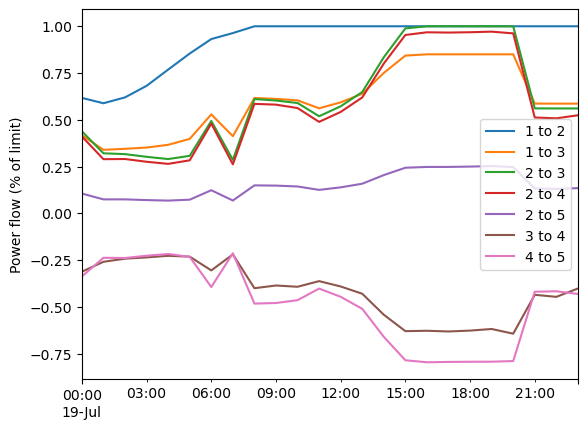

In [10]:
origin, destination = np.triu_indices(model.B.shape[0],1)
line_flows = model.profile.angle.apply(
    lambda row: pd.Series((model.B*outer_difference(row.to_numpy()))[(origin,destination)]),
    axis='columns'
)
line_flows.columns = [f'{origin[k]+1} to {destination[k]+1}' for k in range(len(line_flows.columns))]
lims = model.line_lims[(origin,destination)]
edge_idx = np.nonzero(lims)[0]
line_flows = line_flows.iloc[:,edge_idx]/lims[edge_idx]

fig, ax = plt.subplots()
line_flows.plot(ax=ax)
ax.set_ylabel('Power flow (% of limit)')
fig.show()

State-of-charge computation

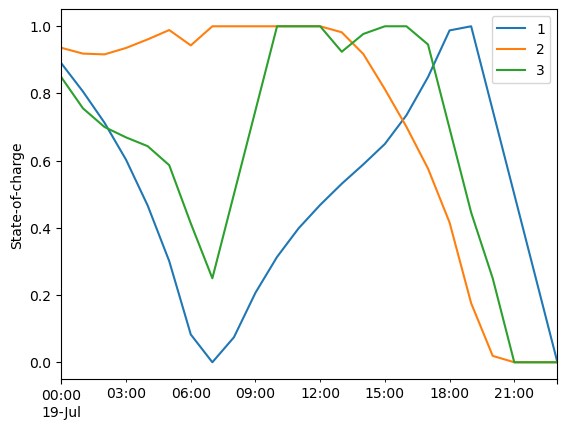

In [11]:
storage_mask = model.storage_capacity >= 1e-3
soc = model.initial_charge + model.profile.storage_load.cumsum()
soc = soc.loc[:,storage_mask]/model.storage_capacity[storage_mask]

fig, ax = plt.subplots()
soc.plot(ax=ax)
ax.set_ylabel('State-of-charge')
fig.show()